In [1]:
# Import section
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import time

import numpy as np 
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [2]:
N_HIDDEN = 128
BATCH_SIZE = 64

# Model Parameters
δ = 1
α = 0.36
β = 0.96
γ = 1
w = 1
r = 0.01
ρ = 0.9
σ_a = 1/np.sqrt(1-ρ**2)

# Ergodic Domain of the problem
kmin, kmax = 0.01, 0.5
act_fun = 'tanh'

In [3]:
# Definition of the neural network, recall that we are trying to approximate the Value function, the policy
# And the lagrange multipliers as function of state. The state variables are k and a

# Here we define a structure for the neural network, then we istantiate each network
# for any function we want to approximate and then I create a function that takes 
# the input (the state variables) and spits out the function, so that it seems more natural later
# to write code
layers = [
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun, input_dim = 1),
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun),
    tf.keras.layers.Dense(N_HIDDEN, activation=act_fun),
    tf.keras.layers.Dense(1)
]

C_net = tf.keras.Sequential(layers)


def cf(k):
    k = (k - kmin)/(kmax - kmin)*2.0 - 1.0
    
    x = tf.concat([k],axis=1)
    return tf.math.sigmoid(C_net(x))

In [4]:
# Utility functions and other useful pretty fantastic functions
def u(c):
    if γ != 1:
        return (c**(1-γ)-1)/(1-γ)
    else:
        return tf.math.log(c)

def d_u(c):
    return c**(-γ)

def d_uinv(a):
    return a**(-1/γ)
    
def f(k):
    return k**α

def d_f(k):
    return α*(k**(α-1))

def FB(a,b):
    return tf.sqrt(a**2 + b**2) - a - b 

def solution(k):
    return (1-α*β)*f(k)

def solution2(k):
    return (α*β)*f(k)

# Preliminary predicition plots

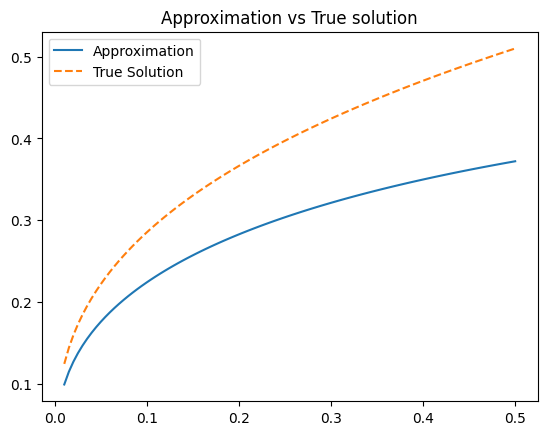

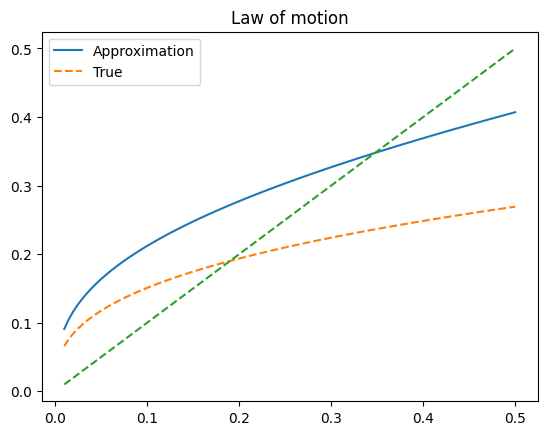

In [5]:
k = tf.constant(np.linspace(kmin,kmax,100,dtype=np.float32),shape=(100,1))

plt.figure()
plt.title('Approximation vs True solution')
share = cf(k)
c = share*(f(k) + (1-δ)*k)
plt.plot(k,c,label='Approximation')
plt.plot(k,solution(k),label='True Solution',linestyle='--')
plt.legend()
plt.show()

plt.figure()
plt.title('Law of motion')
kp = f(k) + (1-δ)*k - c
plt.plot(k,kp,label='Approximation')
plt.plot(k,solution2(k),linestyle='--',label='True')
plt.plot(k,k,linestyle='--')
plt.legend()
plt.show()

In [6]:
def loss_function(n):
    """ The loss function is composed of 3 main blocks:
        1) Sample of the economy today
        2) Transition of the economy tomorrow
        3) Definition of the loss function
        
        The function takes as input the batch_size and put as output several measures that will guide (hopefully)
        the neural network to a good solution"""
    
    # 1) Sample the economy today
    k = tf.random.uniform(shape=(n,1), minval= kmin, maxval= kmax)
    #k = tf.reshape(tf.linspace (kmin,kmax,BATCH_SIZE) ,shape=(BATCH_SIZE,1))

    
    # Evaluate the economy today
    share = cf(k)
    c = share*(f(k) + (1-δ)*k)
    
    # 2) Transition of the economy tomorrow
    k_p = f(k) + (1-δ)*k - c
    share_p = cf(k_p)
    c_p = share_p*(f(k_p) + (1-δ)*k_p)
    
    # Here we specify the FOCS, for the moment I will follow the approach of Villaverde
    # As specified in the slides, using the euler relative error
    h = (β*d_u(c_p)*(d_f(k_p) + (1-δ)))/d_u(c)
    minFB = FB(1 - share, 1 - h)

    
    # Loss functions
    FBerr = tf.reduce_mean(tf.square(minFB)) 
    
    
    return FBerr

In [7]:
thetaC = C_net.trainable_variables
optimizer = Adam(learning_rate=0.001)

In [8]:
@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        # Compute the loss function
        FBerr = loss_function(BATCH_SIZE)
        
    # Compute the gradient of the total loss function with respect to the network parameters    
    gradsC = tape.gradient(FBerr, thetaC)

    
    # Update parameters
    optimizer.apply_gradients(zip(gradsC, thetaC))

    
    return FBerr

In [9]:
def train(epochs):
    # To store the loss in order to plot
    total_losses = []
    
    # Take track of the starting time
    start = time.time()
    
    for i in range(0,epochs):
        clear_output(wait=True)
        FBerr  = training_step()
        
        # Append the loss function
        total_losses.append(FBerr.numpy())
        
        # Take track of the time
        now = time.time()
        
        print(f"""
        percentage: {round((i/epochs)*100,2)}%
        time elapsed: {now - start}
        epoch : {i+1}
        fb : {FBerr.numpy()}
        """)
    return total_losses

In [10]:
total_err = train(1000)


        percentage: 99.9%
        time elapsed: 2.034681558609009
        epoch : 1000
        fb : 4.687546606874093e-06
        


# Plots

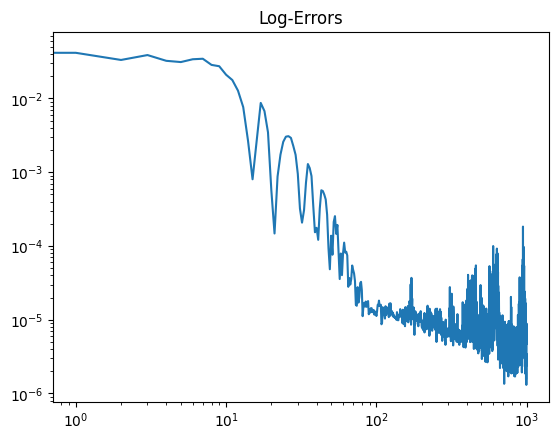

In [11]:
plt.figure()
plt.title('Log-Errors')
plt.xscale('log')
plt.yscale('log')
plt.plot(total_err)
plt.show()

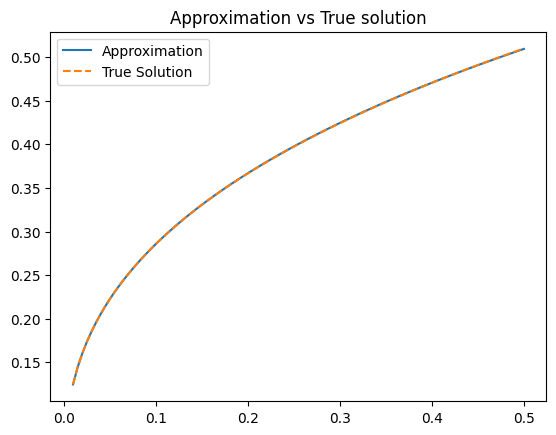

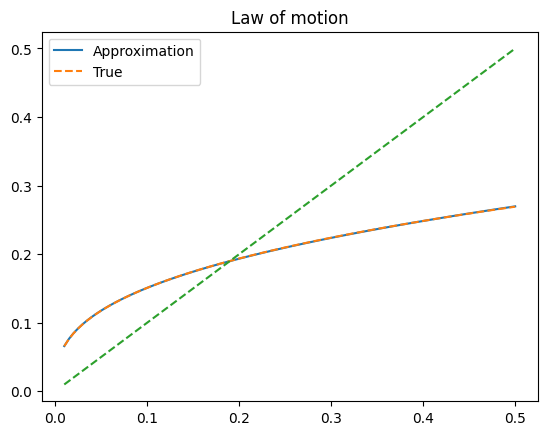

In [12]:
share = cf(k)
c = share*(f(k) + (1-δ)*k)
plt.figure()
plt.title('Approximation vs True solution')
plt.plot(k,c,label='Approximation')
plt.plot(k,solution(k),label='True Solution',linestyle='--')
plt.legend()
plt.show()

plt.figure()
plt.title('Law of motion')
kp = f(k) + (1-δ)*k - c
plt.plot(k,kp,label='Approximation')
plt.plot(k,solution2(k),linestyle='--',label='True')
plt.plot(k,k,linestyle='--')
plt.legend()
plt.show()

In [13]:
C_net.save('Ramsey.h5')